## Basic Imports
This cell imports the SunPy library and astropy library, along with pyplot.

In [1]:
import sunpy.map
import sunpy.data.sample
import sunpy.timeseries as ts
from sunpy.net import Fido, attrs as a
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt

C:\Users\wills\AppData\Roaming\jupyterlab-desktop\envs\env_sunpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and Load AIA Map

This cell searches for and downloads AIA 171 A (extreme ultraviolet) image data from the SDO (Solar Dynamics Observatory) for a specific time using the Fido search client. The first returned file is loaded as a SunPy Map, which stores both image data and metadata. Then, object oriented plotting is used to create the SunPy map.


2025-05-17 17:21:19 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Text(0.5, 1.0, 'AIA 171 A Sample Image')

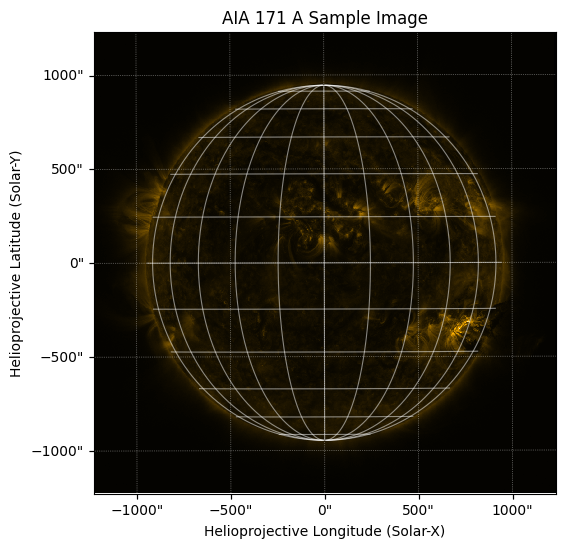

In [2]:
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='sdoaia171')
aia_map.draw_grid(axes=ax)
ax.set_title("AIA 171 A Sample Image")

## Download and Plot GOES X-ray Flux (June 1–2, 2012)

This cell searches for and downloads GOES X-ray flux data for June 1–2, 2012 using Fido. It loads each file into a SunPy `TimeSeries` object and concatenates them into one combined time series. The resulting data is presented using object-oriented plotting, showing solar X-ray flux in two wavelength channels. This helps visualize solar flare activity during the selected period. I had difficulty getting this cell to work with anything after 2020, and a lot of the timespans after 2012 did not plot correctly.

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00, 10.46file/s]


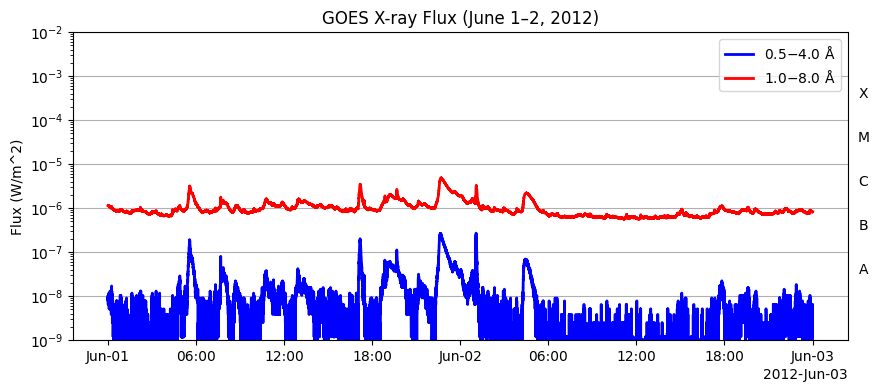

In [3]:
time_range = a.Time("2012-06-01", "2012-06-02")
instrument = a.Instrument.xrs

results = Fido.search(time_range, instrument)
files = Fido.fetch(results)
ts_list = [ts.TimeSeries(file, source='XRS') for file in files]

combined_ts = ts_list[0]
for t in ts_list[1:]:
    combined_ts = combined_ts.concatenate(t)

fig, ax = plt.subplots(figsize=(10, 4))
combined_ts.plot(axes=ax)
ax.set_title("GOES X-ray Flux (June 1–2, 2012)")
ax.set_ylabel("Flux (W/m^2)")
plt.show()


## Convert to Image Coordinates

This cell picks a point on the Sun using solar latitude and longitude, then converts that point into image (pixel-like) coordinates so it can be used with the AIA image. This is needed if we want to zoom in or mark specific regions on the Sun's surface.

In [4]:
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord

coord = SkyCoord(10*u.deg, 30*u.deg, frame=frames.HeliographicStonyhurst, obstime=aia_map.date)
hpc_coord = coord.transform_to(frames.Helioprojective(observer=aia_map.observer_coordinate))

print(f"Transformed HPC Coordinates: {hpc_coord}")

Transformed HPC Coordinates: <SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.880, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.880, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00406429, 0.04787238, 1.51846026e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (142.73164436, 473.69025522, 1.51252838e+08)>


## Plot Point on AIA Image

This cell plots the AIA image again and marks the transformed point from earlier (in red) on the image. A grid is added for context, and a legend helps identify the overlaid point. This is useful for highlighting specific locations on the Sun.


Text(0.5, 1.0, 'AIA Map with Helioprojective Point Overlay')

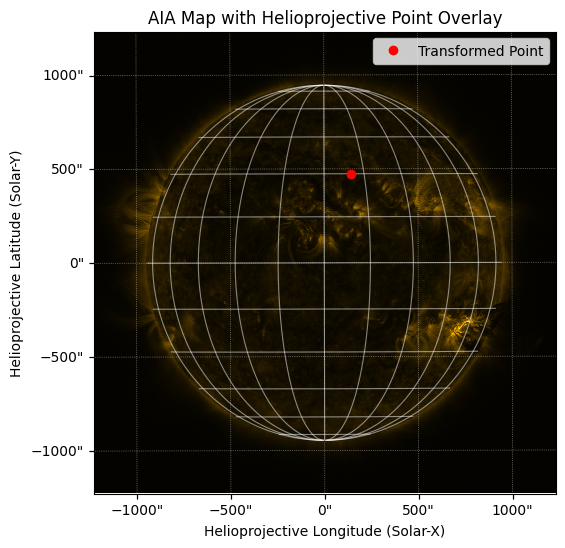

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, cmap='sdoaia171')
aia_map.draw_grid(axes=ax)

ax.plot_coord(hpc_coord, 'o', color='red', label='Transformed Point')
ax.legend()
ax.set_title("AIA Map with Helioprojective Point Overlay")

## Zoom In on a Region of the Sun

This cell defines a small box around the red point from earlier and creates a zoomed-in version of the AIA image (a "submap"). It then plots just that region, letting us take a closer look at activity near the target location on the Sun.

Text(0.5, 1.0, 'AIA Submap around Target Coordinate')

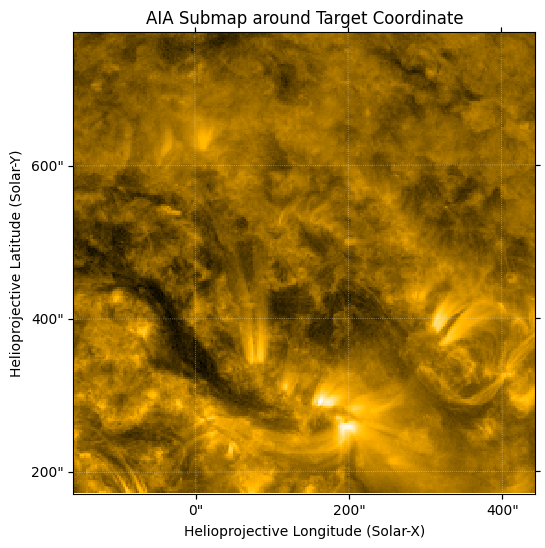

In [6]:
tx = hpc_coord.Tx
ty = hpc_coord.Ty

bottom_left = SkyCoord(tx - 300 * u.arcsec, ty - 300 * u.arcsec, frame=aia_map.coordinate_frame)
top_right   = SkyCoord(tx + 300 * u.arcsec, ty + 300 * u.arcsec, frame=aia_map.coordinate_frame)

submap = aia_map.submap(bottom_left=bottom_left, top_right=top_right)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=submap)
submap.plot(axes=ax)
ax.set_title("AIA Submap around Target Coordinate")